# Offensive Prescriptions: Are some medications more corellated with criminal offenses?

Here we examine the police offenses and prescription data from England to try to find out.


### Let's start by importing a subset of the police data and expand from there

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import folium
from folium.plugins import HeatMap

In [2]:
# police = pd.read_csv("./police-data/2016-05/2016-05-metropolitan-street.csv")
# police = pd.read_csv('./police-data/2016-05/2016-05-north-yorkshire-street.csv')

In [3]:
# paths = []
# for j in range(2016,2018):
#     j = str(j)
#     for i in range(1,13):
#         i = str(i)
#         if len(i)==1:
#             i = '0'+i
#         paths.append('./police-data/'+j+'-'+i+'/'+j+'-'+i+'-metropolitan-street.csv')
#         #paths.append('./201703to202002police/'+j+'-'+i+'/'+j+'-'+i+'-city-of-london-street.csv')
# paths = paths[5:17]

In [4]:
paths = []
for j in range(2016,2018):
    j = str(j)
    for i in range(1,13):
        i = str(i)
        if len(i)==1:
            i = '0'+i
#         paths += glob.glob('./police-data/'+j+'-'+i+'/'+j+'-'+i+'*-street.csv')
        paths += glob.glob('./police-data/'+j+'-'+i+'/'+j+'-'+i+'*metropolitan-street.csv')
        paths += glob.glob('./police-data/'+j+'-'+i+'/'+j+'-'+i+'*london-street.csv')
# paths = paths[178:]
paths = paths[8:]
paths;

In [5]:
# police = police.drop(['Crime ID','Reported by', 'Falls within','Location',
#                       'LSOA code','LSOA name','Last outcome category',
#                       'Context'], axis = 1).dropna(subset = ["Longitude","Latitude"])

In [6]:
# # for i in paths:
# #     police = pd.concat([police,pd.read_csv(i)])
# for i in paths:
#     temp = pd.read_csv(i).drop(['Crime ID','Reported by', 'Falls within','Location','LSOA code',
#                                 'LSOA name','Last outcome category', 'Context'], axis = 1)
#     temp = temp.dropna(subset = ["Longitude","Latitude"])
#     police = pd.concat([police,temp])
# temp = None
police = []
for i in paths:
    temp = pd.read_csv(i).drop(['Crime ID','Reported by', 'Falls within','Location','LSOA code',
                                'LSOA name','Last outcome category', 'Context'], axis = 1)
    temp = temp.dropna(subset = ["Longitude","Latitude"])
    police.append(temp.copy())

temp = None
police = pd.concat(police)

In [7]:
police['count']=1

In [8]:
police.size

5523615

In [9]:
# police.groupby(['Crime type']).sum()

In [10]:
police.head()

,Month,Longitude,Latitude,Crime type,count
0,2016-05,0.863819,51.158786,Burglary,1
1,2016-05,0.134947,51.588063,Anti-social behaviour,1
2,2016-05,0.134947,51.588063,Anti-social behaviour,1
3,2016-05,0.135866,51.587336,Anti-social behaviour,1
4,2016-05,0.140192,51.582311,Anti-social behaviour,1


### The GP prescription data has a lot of work that needs to be done

Particularly, the locations (preferably latitude and longitude) of the practices needs to be identified from the postal codes.

In [11]:
practice_header = ['practice','name','location_1','location_2','location_3','location_4','postal_code']
practice = pd.read_csv('./general-practice-prescribing-data/practices.csv',
                       names = practice_header).dropna(subset=['postal_code'])

In [12]:
practice.head()

,practice,name,location_1,location_2,location_3,location_4,postal_code
0,A81001,THE DENSHAM SURGERY,THE HEALTH CENTRE,LAWSON STREET,STOCKTON ON TEES,CLEVELAND,TS18 1HU
1,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW
2,A81003,VICTORIA MEDICAL PRACTICE,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,TS26 8DB
3,A81004,WOODLANDS ROAD SURGERY,6 WOODLANDS ROAD,NaN,MIDDLESBROUGH,CLEVELAND,TS1 3BE
4,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,TS14 7DJ


### Let's try a lookup method of determining coordinates from name and postal_code

In [13]:
# from geopy.geocoders import Nominatim

In [14]:
# practice_location = practice.drop(['practice','location_1','location_2','location_3','location_4'], axis=1)

In [15]:
# t = practice_location.iloc[1].to_list()
# t = t[0]+' '+t[1]
# t

In [16]:
# st = time.time()
# geolocator = Nominatim(user_agent="Offensive Prescriptions")
# location = geolocator.geocode(t)
# print(time.time() - st)
# print(location)
# print((location.latitude, location.longitude))

It works, but takes about .5 seconds to lookup. That means a total of about 12 hours to lookup all 84140 practices. No problem normally, but time is limited now.

In [17]:
# t = practice_location.iloc[2].to_list()
# t = t[0]+' '+t[1]
# t

In [18]:
# st = time.time()
# geolocator = Nominatim(user_agent="Offensive Prescriptions")
# location = geolocator.geocode(t)
# print(time.time() - st)
# print(location)
# if location:
#     print((location.latitude, location.longitude))

In [19]:
# practice_location= None

Sometimes it doesn't work and until we process all of them we don't really know how many will fail. Google found this without problem, but open street map couldn't.

### For now let's use a table of latitude and longitude for the postal codes.

This will be less accurate, but may be good enough to get started

In [20]:
postcodes = pd.read_csv('./ukpostcodes.csv').drop(['id'], axis = 1)

In [21]:
postcodes.head()

,postcode,latitude,longitude
0,AB10 1XG,57.144165,-2.114848
1,AB10 6RN,57.137880,-2.121487
2,AB10 7JB,57.124274,-2.127190
3,AB11 5QN,57.142701,-2.093295
4,AB11 6UL,57.137547,-2.112233


In [22]:
postcodes.latitude[postcodes.postcode == 'AB10 1XG']

0    57.144165
Name: latitude, dtype: float64

In [23]:
postcodes = postcodes.set_index('postcode')
practice = practice.set_index('postal_code')
practice = practice.join(postcodes)

In [24]:
postcodes = None

In [25]:
practice = practice.reset_index()

In [26]:
practice['index'].iloc[1]

'AL1 3JB'

In [27]:
practice = practice.drop(['name','location_1','location_2','location_3','location_4'],axis=1)
practice.head()

,index,practice,latitude,longitude
0,AL1 3HD,E82060,51.756626,-0.334037
1,AL1 3JB,E82031,51.751858,-0.337904
2,AL1 4JE,E82004,51.751799,-0.322346
3,AL10 0BS,E82002,51.766263,-0.227045
4,AL10 0LF,Y05146,51.763148,-0.224691


### Now we want to make a new giant dataframe containing the distance from each practice to each crime.

Ultimately this will be even bigger because we will want to know this data on a per medication basis for the top N medications.

In [28]:
#police = police.dropna(subset=['Latitude',"Longitude"])

In [29]:
jointable = pd.read_json('./general-practice-prescribing-data/column_remapping.json').drop(['bnf_code','bnf_name'], axis = 1)

In [30]:
codes = pd.read_json('./general-practice-prescribing-data/column_remapping.json').drop(['practice'], axis = 1)

In [31]:
codes = codes.dropna()

In [32]:
# prescribe = pd.read_csv("./general-practice-prescribing-data/T201605PDPI+BNFT.csv")
# prescribe['month'] = "2016-05"
# prescribe.size

In [33]:
# prescribe = prescribe.drop(['bnf_name','items','nic'],axis = 1).dropna(subset = ['practice','bnf_code'])

In [34]:
# prescribe.size

In [35]:
# prescribe.head()

In [36]:
# preappend = pd.read_csv("./general-practice-prescribing-data/T201606PDPI+BNFT.csv")
# preappend['month'] = 201606
# prescribe = pd.concat([prescribe,preappend])
# preappend = pd.read_csv("./general-practice-prescribing-data/T201606PDPI+BNFT.csv")
# preappend['month'] = 201606
# prescribe = pd.concat([prescribe,preappend])
# preappend = None
st = time.time()
paths = sorted(glob.glob('./general-practice-prescribing-data/*BNFT.csv'))
# prescribe = prescribe.set_index('practice').join(jointable)
# prescribe = prescribe.set_index('practice').join(practice.set_index('practice'))
counter = 1
# for i in paths[1:]:
prescribe = []
for i in paths:
    #loading
    temp = pd.read_csv(i).drop(['bnf_name','items','nic'],axis = 1).dropna(subset = ['practice','bnf_code'])
    temp['month'] = i[37:41]+'-'+i[41:43]
    print(str(counter)+"a",time.time()-st)
    
    #getting zip codes on index
    temp = temp.set_index('practice').join(jointable)
    print(str(counter)+"b",time.time()-st)
    
    temp = temp.set_index('practice').join(practice.set_index('practice'))
    print(str(counter)+"c",time.time()-st)
    
#     temp = temp.dropna(subset = 'latitude')

    #combining
    prescribe.append(temp)
#     prescribe = pd.concat([prescribe,temp])
    print(str(counter)+"d",time.time()-st)

    counter+=1
temp = None
prescribe = pd.concat(prescribe)
print('concat',time.time()-st)
prescribe.head()

1a 14.069252252578735
1b 17.950695037841797
1c 24.486984968185425
1d 24.488445043563843
2a 36.36811017990112
2b 40.09646511077881
2c 46.769404888153076
2d 46.770004987716675
3a 57.92825126647949
3b 62.2772901058197
3c 68.84073305130005
3d 68.84100198745728
4a 81.3215081691742
4b 85.64801216125488
4c 92.13433814048767
4d 92.13455700874329
5a 104.82891321182251
5b 109.16827321052551
5c 116.62092804908752
5d 116.6215751171112
6a 128.24824810028076
6b 132.60039401054382
6c 139.49379706382751
6d 139.49560117721558
7a 153.08277297019958
7b 157.21684622764587
7c 163.63773608207703
7d 163.6379680633545
8a 176.57363295555115
8b 181.38299798965454
8c 187.72737908363342
8d 187.73785710334778
9a 199.45151901245117
9b 205.67354011535645
9c 212.25171995162964
9d 212.25193405151367
10a 224.60875487327576
10b 228.89572095870972
10c 235.64198803901672
10d 235.64261603355408
11a 249.05492210388184
11b 253.5491180419922
11c 260.02494525909424
11d 260.02615094184875
12a 271.8717529773712
12b 276.425293207

,bnf_code,act_cost,quantity,month,index,latitude,longitude
practice,,,,,,,
A81001,2032,2.78,500,2016-05,TS18 1HU,54.561625,-1.318986
A81001,2032,2.78,500,2016-05,TS18 1HU,54.561625,-1.318986
A81001,12593,2.52,50,2016-05,TS18 1HU,54.561625,-1.318986
A81001,12593,2.52,50,2016-05,TS18 1HU,54.561625,-1.318986
A81001,15151,4.32,49,2016-05,TS18 1HU,54.561625,-1.318986


In [37]:
prescribe.size

1010756439

In [38]:
# paths = []
# for j in range(2016,2018):
#     j = str(j)
#     for i in range(1,13):
#         i = str(i)
#         if len(i)==1:
#             i = '0'+i
#         paths.append('./general-practice-prescribing-data/T'+j+i+'PDPI+BNFT.csv')
#         #paths.append('./201703to202002police/'+j+'-'+i+'/'+j+'-'+i+'-city-of-london-street.csv')
# paths = paths[5:4+13]
# paths

Loading all the months is too much for my toaster to handle.

In [39]:
# for i in paths:
#     t = pd.read_csv(i)
#     t['month'] = i[37:43]
#     prescribe = pd.concat([prescribe,pd.read_csv(i)])

Bringing it all together in the prescribe dataframe:

In [40]:
# st = time.time()
# print(st)
# prescribe = prescribe.set_index('practice').join(jointable)
# jointable = None
# print(time.time()-st)
# prescribe = prescribe.set_index('practice')
# print(time.time()-st)
# prescribe = prescribe.join(practice.set_index('practice'))
# practice = None
# print(time.time()-st)
# prescribe = prescribe.reset_index()
# print(time.time()-st)
# prescribe.head()

### Let's try to reduce the prescriber data by focusing on the top most prescribed medications
upon review the code below seems to do nothing

In [41]:
# t = prescribe[['bnf_code',"quantity"]].groupby('bnf_code').sum()
# t=t.reset_index()
# tcode = t.bnf_code.tolist()
# t = None
# p = prescribe[prescribe.bnf_code.isin(tcode)]

In [42]:
# p.size
# # former p.size is 540667760

### Here we now need to give each crime a medication weight which should be something like the sum of the items/(distance from crime to prescriber)

So we need to do this for each item in police...

In [43]:
# def distance(la1,lo1,la2,lo2):
#     return ((la1-la2)**2+(lo1-lo2)**2)**.5
# def weight(items, dist):
#     return items/dist
# def weight2(items, dist):
#     return 2./(1+np.exp(d/items))

In [44]:
# for i in tcode:
#     police[str(i)] = p[p.bnf_code == i]

I don't have the ability yet to construct this dataframe using pandas. I'm going to try to do it by building a dictionary

In [45]:
# st = time.time()
# weight_sum = 0
# for j in p.iterrows():
#         #w[str(i)] = 
#         count+=1
# print(time.time()-st)

This takes about a minute to run. I would have to run a similar loop once for every crime. That would take the better part of a year to execute. This is too slow

In [46]:
police['coords'] = list(zip(police['Latitude'],police['Longitude']))

In [97]:
#police.groupby(['coords','Crime type']).sum()
pol = police.groupby('coords').sum()

In [98]:
pol = pol[pol['count']>1]

In [99]:
pol['Latitude'],pol['Longitude'] = zip(*pol.index.tolist())

In [100]:
pol = pol.reset_index()

In [101]:
pol.size

223088

Now that I've cut down the police data by grouping coordinates together, which seemed justified considering the coordinate anonymizing done by the police, I think I can construct my dictionary.

In [117]:
p = prescribe.drop(['act_cost','month'],axis=1).dropna(subset = ['latitude']).copy()
#move this up to the loading and concat area

In [118]:
# ptemp = p.groupby('bnf_code').sum()
# ptemp = ptemp[ptemp.quantity>2000000000]
# ptemp = ptemp.index.tolist()
# len(ptemp)

In [119]:
proz = codes[codes.bnf_name.str.contains('Fluox')].index.tolist()+codes[codes.bnf_name.str.contains('Prozac')].index.tolist()
proz

[10869,
 11030,
 14694,
 15873,
 18239,
 18384,
 1851,
 2976,
 4906,
 7553,
 783,
 8574,
 9975,
 21210,
 579]

In [120]:
ibu = codes[codes.bnf_name.str.contains('Ibu')].index.tolist()
# for i in range(len(ibu)):
#     ibu[i] = str(ibu[i])
oxy = codes[codes.bnf_name.str.contains('Oxycod')].index.tolist()
# for i in range(len(oxy)):
#     oxy[i] = str(oxy[i])
proz = codes[codes.bnf_name.str.contains('Fluox')].index.tolist()+codes[codes.bnf_name.str.contains('Prozac')].index.tolist()
ptemp = ibu + oxy + proz
ptemp;

In [121]:
# convert medications to strings so that we can find them with a custom function
for i in range(len(ptemp)):
    ptemp[i] = str(ptemp[i])

In [122]:
p = p[p.bnf_code.isin(ptemp)]

In [123]:
p.head()

,bnf_code,quantity,index,latitude,longitude
practice,,,,,
A81002,17849,3,TS18 2AW,54.569163,-1.313928
A81002,8709,112,TS18 2AW,54.569163,-1.313928
A81002,4252,120,TS18 2AW,54.569163,-1.313928
A81002,15473,224,TS18 2AW,54.569163,-1.313928
A81002,18239,4,TS18 2AW,54.569163,-1.313928


In [124]:
# prescribe = None

In [125]:
p['coords'] = list(zip(p['latitude'],p['longitude']))

In [126]:
poxy = p[p.bnf_code.isin(oxy)].groupby(['coords']).sum()
poxy.bnf_code = "oxy"
pibu = p[p.bnf_code.isin(ibu)].groupby(['coords']).sum()
pibu.bnf_code = 'ibu'
pproz = p[p.bnf_code.isin(proz)].groupby(['coords']).sum()
pproz.bnf_code = 'proz'
# poxy = poxy.rename(columns={"bnf_code": "bnf_oxy", "quantity": "quantity_oxy"}).drop(['latitude','longitude'],axis=1)
# pibu = pibu.rename(columns={"bnf_code": "bnf_ibu", "quantity": "quantity_ibu"}).drop(['latitude','longitude'],axis=1)

In [127]:
p = pd.concat([pibu,poxy,pproz],axis=0,sort=False)

In [128]:
p = p.groupby(['coords','bnf_code']).sum().reset_index()

In [129]:
p['latitude'],p['longitude'] = zip(*p.coords.tolist())

Now I've also cut down the prescriptions, by grouping them together by bnf_code and practice

# Starting from here NEW CODE

In [130]:
# pr = p.drop(['items','nic','act_cost','month'],axis=1).copy()
# pr = pr.dropna(subset = ['latitude'])

In [131]:
poli = pol.copy()

In [132]:
# pol = None
# police = None

In [133]:
# def weigh(x):
#     if x.name in ptemp: # now the function is only operating on the columns I want
#         print(x.name)
#     return x

In [134]:
# t = pol.apply(weigh)

In [135]:
#basic testing with numpy.ufunc.outer to vectorize
pol_lat = np.array([1, 2, 3])
pr_lat = np.array([5 ,7])
pol_long = np.array([11, 13, 17])
pr_long = np.array([23, 29])
q = np.array([5, 167])
D = np.sqrt(np.square(np.subtract.outer(pol_lat, pr_lat)) +
            np.square(np.subtract.outer(pol_long, pr_long)))
# w = 2./(1 + np.exp(D/q)) # sigmoid-like weight
sig = np.std(D,axis = 0)
srexp = np.divide(D-np.mean(D,axis = 0),sig)
w = q*np.exp(-np.multiply(srexp,srexp)/2) # gaussian weight
w

array([[  2.77449121,  92.63880826],
       [  4.85507958, 162.17719268],
       [  2.07056364,  69.17114309]])

Using numpy.ufunc.outer seems to work. I don't know how fast it will be, but it has to be faster than going element by element.

w is indexed by the index of the police dataframe which is analogous to the police coordinates. It has columns of the prescription coordinates.

This is fine except that after the math there's no way to separate them by medication. 
We can separate them beforehand maybe since we don't map multiple at the same time. Then sum each row in w to get just the total weight for each coordinate. Then stitch together different medications to form the final output.

In [136]:
prt = p[p.bnf_code == 6079].head(7).copy()
polit = poli.head().copy()
D = np.sqrt(np.square(np.subtract.outer(polit.Latitude, prt.latitude)) +
            np.square(np.subtract.outer(polit.Longitude, prt.longitude)))
q = prt.quantity
qq = np.array(q).reshape(1,q.size)
# c = polit['count']
# cc = np.array(c).reshape(c.size,1)
# w = 2./(1 + np.exp(np.divide(D*100000,np.multiply(qq,cc))))
# w = 2./(1 + np.exp(np.divide(D*1000,qq)))# sigmoid weight
sig = np.std(D,axis = 0)
srexp = np.divide(D-np.mean(D,axis = 0),sig)
w = qq*np.exp(-np.multiply(srexp,srexp)/2)# gaussian weight
# I may have to normalize the distance, quantities, and counts in the future
w = pd.DataFrame(w.sum(axis = 1),columns = ['6079'],index = polit.index)
polit['6079'] = w
polit['6079'] = polit['6079']*polit['count']
polit

,coords,Longitude,Latitude,count,6079
0,"(50.819097, -0.136492)",-0.136492,50.819097,2,0.0
1,"(50.822588, -0.145056)",-0.145056,50.822588,3,0.0
2,"(50.830219, -0.14197)",-0.141970,50.830219,2,0.0
3,"(50.833571, -0.290611)",-0.290611,50.833571,2,0.0
4,"(50.845285, -0.19422899999999998)",-0.194229,50.845285,2,0.0


In [137]:
polit = poli.head().copy()
for i in p.bnf_code.unique():
    prt = p[p.bnf_code == i].head(7).copy()
    D = np.sqrt(np.square(np.subtract.outer(polit.Latitude, prt.latitude)) +
            np.square(np.subtract.outer(polit.Longitude, prt.longitude)))
    q = prt.quantity
    qq = np.array(q).reshape(1,q.size)
#     w = 2./(1 + np.exp(np.divide(D*1000,qq))) # sigmoid weight
    sig = np.std(D,axis = 0)
    srexp = np.divide(D-np.mean(D,axis = 0),sig)
    w = qq*np.exp(-np.multiply(srexp,srexp)/2) # gaussian weight
    # I may have to normalize the distance, quantities, and counts in the future
    w = pd.DataFrame(w.sum(axis = 1),columns = [str(i)],index = polit.index)
    polit[str(i)] = w
    polit[str(i)] = polit[str(i)]*polit['count']
polit

,coords,Longitude,Latitude,count,ibu,oxy,proz
0,"(50.819097, -0.136492)",-0.136492,50.819097,2,276197.287198,19002.041942,112.625322
1,"(50.822588, -0.145056)",-0.145056,50.822588,3,456053.252557,31365.634827,186.031779
2,"(50.830219, -0.14197)",-0.141970,50.830219,2,289916.093288,19927.424358,118.339506
3,"(50.833571, -0.290611)",-0.290611,50.833571,2,62549.939477,4295.872849,25.555516
4,"(50.845285, -0.19422899999999998)",-0.194229,50.845285,2,361726.882948,24876.935363,147.562109


## Let's try with all the data

In [139]:
p

,coords,bnf_code,quantity,latitude,longitude
0,"(49.9126243289637, -6.30890191279307)",ibu,1424,49.912624,-6.308902
1,"(49.9126243289637, -6.30890191279307)",oxy,900,49.912624,-6.308902
2,"(50.025249, -5.244065)",ibu,19536,50.025249,-5.244065
3,"(50.025249, -5.244065)",oxy,6560,50.025249,-5.244065
4,"(50.025249, -5.244065)",proz,8,50.025249,-5.244065
5,"(50.0484424697773, -5.09119709929876)",ibu,32801,50.048442,-5.091197
6,"(50.0484424697773, -5.09119709929876)",oxy,2671,50.048442,-5.091197
7,"(50.0484424697773, -5.09119709929876)",proz,10,50.048442,-5.091197
8,"(50.0919451534235, -5.26493170578654)",ibu,42,50.091945,-5.264932
9,"(50.098411496160494, -5.27138544609716)",ibu,38340,50.098411,-5.271385


In [145]:
st = time.time()
for i in p.bnf_code.unique():
    prt = p[p.bnf_code == i]#.head(500)
    D = np.sqrt(np.square(np.subtract.outer(poli.Latitude, prt.latitude)) +
            np.square(np.subtract.outer(poli.Longitude, prt.longitude)))
    q = prt.quantity
    qq = np.array(q).reshape(1,q.size)
#     w = 2./(1 + np.exp(np.divide(D*1000,qq)))
    # I may have to normalize the distance, quantities, and counts in the future
    
    sig = np.std(D,axis = 0)
    srexp = np.divide(D-np.mean(D,axis = 0),sig)
    w = qq*np.exp(-np.multiply(srexp,srexp)/2) # gaussian weight
    
    w = pd.DataFrame(w.sum(axis = 1),columns = [str(i)],index = poli.index)
    poli[str(i)] = w
    poli[str(i)] = poli[str(i)]*poli['count']
print(time.time()-st)
poli

2662.95264005661


,coords,Longitude,Latitude,count,ibu,oxy,proz
0,"(50.819097, -0.136492)",-0.136492,50.819097,2,5.712340e+07,2.658183e+06,2.138852e+05
1,"(50.822588, -0.145056)",-0.145056,50.822588,3,8.567079e+07,4.037484e+06,3.185641e+05
2,"(50.830219, -0.14197)",-0.141970,50.830219,2,5.800003e+07,2.729158e+06,2.175484e+05
3,"(50.833571, -0.290611)",-0.290611,50.833571,2,5.436360e+07,2.997527e+06,1.922254e+05
4,"(50.845285, -0.19422899999999998)",-0.194229,50.845285,2,5.769271e+07,2.907746e+06,2.084938e+05
5,"(50.855309000000005, 0.559363)",0.559363,50.855309,2,1.388034e+07,1.497039e+06,1.507913e+05
6,"(51.154185999999996, -0.184041)",-0.184041,51.154186,2,1.578835e+08,7.747066e+06,6.644317e+05
7,"(51.15599, -0.163049)",-0.163049,51.155990,5,3.849186e+08,1.885759e+07,1.657567e+06
8,"(51.158444, -0.16410999999999998)",-0.164110,51.158444,19,1.479625e+09,7.247196e+07,6.372374e+06
9,"(51.189856, 0.270367)",0.270367,51.189856,2,2.975838e+07,2.118906e+06,3.389836e+05


## Visualizing the data

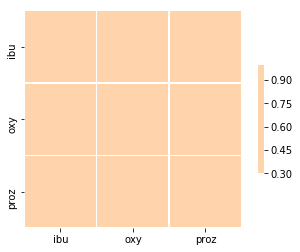

In [146]:
corrmat = poli.drop(['coords','Longitude','Latitude','count'],axis = 1).corr()
# plt.figure(figsize = (40,40))
sns.heatmap(corrmat, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [147]:
corrmat

,ibu,oxy,proz
ibu,1.000000,0.999936,0.999313
oxy,0.999936,1.000000,0.999302
proz,0.999313,0.999302,1.000000


In [155]:
plotdata = list(zip(poli.Latitude,poli.Longitude,poli['proz']))

In [156]:
m = folium.Map(location=[51.51, -.1],zoom_start=12)
HeatMap(data = plotdata[:len(plotdata)],radius=7).add_to(m)
m
# map reportedly doesn't display in Chrome with more than 66150 data points. Works in Firefox, but is pretty slow.

In [78]:
plotdata = None
m=None

Unfortunately the map doesn't seem to show anything too conclusive. There do appear to be some minor hotspots, but overall the data seems to be spread somewhat uniformly.

In the future, I might want to normalize the data for each medication by the total medication supply so that I can compare the medications to each other.

It also definitely needs to be normalized by the population or something equivalent. I think that can be handled in the prescription information without the need for additional demographics.

## Different analysis

Total money paid out in medication vs crime.